In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

In [2]:
def get_centroid(word_forms, model):
    vectors = [model.wv[word] for word in word_forms if word in model.wv]
    if not vectors:
        return None
    centroid = np.mean(vectors, axis=0)
    return centroid

In [3]:
def calculate_distance(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

In [4]:
import json
file_path = 'all_forms_dict.json'

with open(file_path, 'r') as file:
    all_forms_dict = json.load(file)

In [5]:
all_forms_dict['хохол']

['хохла',
 'хохлу',
 'хохлам',
 'хохлом',
 'хохлами',
 'хохле',
 'хохлах',
 'хохлов',
 'хохол',
 'хохлы']

In [6]:
all_forms_dict['укр']

['укр']

In [7]:
models_path = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time'

In [8]:
models_path_few_epoch = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time_few_ep'

In [9]:
models_path_more_epoch = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time_more_ep'


In [10]:
terms = [all_forms_dict['украинец']] + [all_forms_dict['укроп']]
terms

[['украинца',
  'украинце',
  'украинцам',
  'украинцем',
  'украинцах',
  'украинцы',
  'украинцами',
  'украинцев',
  'украинцу',
  'украинец'],
 ['укропу',
  'укропов',
  'укропах',
  'укропом',
  'укроп',
  'укропам',
  'укропами',
  'укропы',
  'укропа',
  'укропе']]

In [11]:
all_forms_dict['укропский']

['укропскими',
 'укропской',
 'укропского',
 'укропским',
 'укропскою',
 'укропские',
 'укропское',
 'укропском',
 'укропский',
 'укропских',
 'укропская',
 'укропскому',
 'укропскую']

In [12]:
def extract_time_period(model_name):
    match = re.search(r'(\d{4}-\d{2}-\d{2})_to_(\d{4}-\d{2}-\d{2})', model_name)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [13]:
import pymorphy2

def get_word_forms(word):
    morph = pymorphy2.MorphAnalyzer()
    if word == 'укр':
        return ['укр', 'укра', 'укру', 'укром', 'укре', 'укры','укров', 'украм', 'украми', 'украх']  # replace with actual forms if needed

    parsed_word = morph.parse(word)
    forms = []
    for parse_result in parsed_word:
        for form in parse_result.lexeme:
            forms.append(form.word)
    return forms

In [14]:
# def plot_denotation_divergence_w_time(all_forms_dict, term_one, term_two, models_path):
#     terms = get_word_forms(term_one) + get_word_forms(term_two)
#     distance_list = []
#     time_periods = []
#     for model_name in sorted(os.listdir(models_path)):
#         if not model_name.endswith('.model'):
#             continue
#
#         start_date, end_date = extract_time_period(model_name)
#         if not start_date or not end_date:
#             continue
#
#         model_path = os.path.join(models_path, model_name)
#         model = Word2Vec.load(model_path)
#
#         centroid1 = get_centroid(terms[0], model)
#         centroid2 = get_centroid(terms[1], model)
#
#         if centroid1 is None or centroid2 is None:
#             continue
#
#         distance = calculate_distance(centroid1, centroid2)
#         distance_list.append(distance)
#         time_periods.append(f'{start_date} - {end_date}')
#
#     plt.figure(figsize=(10, 6))
#     plt.plot(distance_list)
#     plt.xticks(range(len(time_periods)), time_periods, rotation=90)
#     plt.xlabel('Time Periods')
#     plt.ylabel('Cosine distance')
#     plt.title('Denotation Divergence in Time of Terms {} and {}'.format(term_one, term_two))
#     plt.tight_layout()
#     plt.show()

In [15]:
def plot_denotation_divergence_w_time(all_forms_dict, term_one, term_two, models_path):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two)
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')

    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = calculate_distance(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date} - {end_date}')

    plt.figure(figsize=(10, 6))
    plt.plot(distance_list)
    plt.xticks(range(len(time_periods)), time_periods, rotation=90)
    plt.xlabel('Time Periods')
    plt.ylabel('Cosine distance')
    plt.title('Denotation Divergence in Time of Terms {} and {}'.format(term_one, term_two))
    plt.tight_layout()
    plt.show()

## For 10 epochs

['укр', 'укра', 'укру', 'укром', 'укре', 'укры', 'укров', 'украм', 'украми', 'украх']
********************************************************************************
['хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохла', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлов', 'хохлами', 'хохлах']


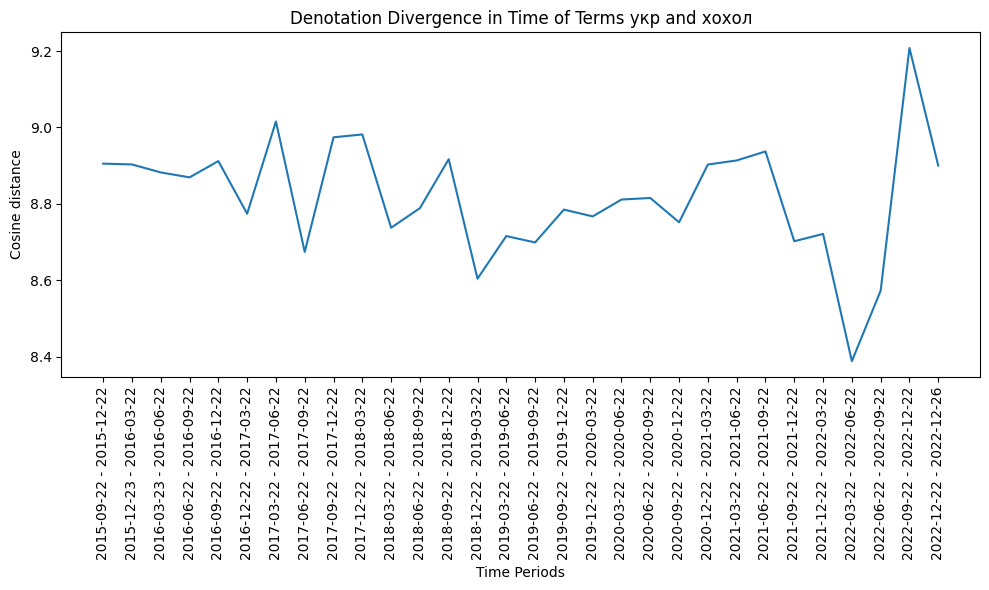

CPU times: user 1min 23s, sys: 10.3 s, total: 1min 33s
Wall time: 1min 45s


In [16]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'укр', 'хохол', models_path)

['украинец', 'украинца', 'украинцу', 'украинца', 'украинцем', 'украинце', 'украинцы', 'украинцев', 'украинцам', 'украинцев', 'украинцами', 'украинцах']
********************************************************************************
['укр', 'укра', 'укру', 'укром', 'укре', 'укры', 'укров', 'украм', 'украми', 'украх']


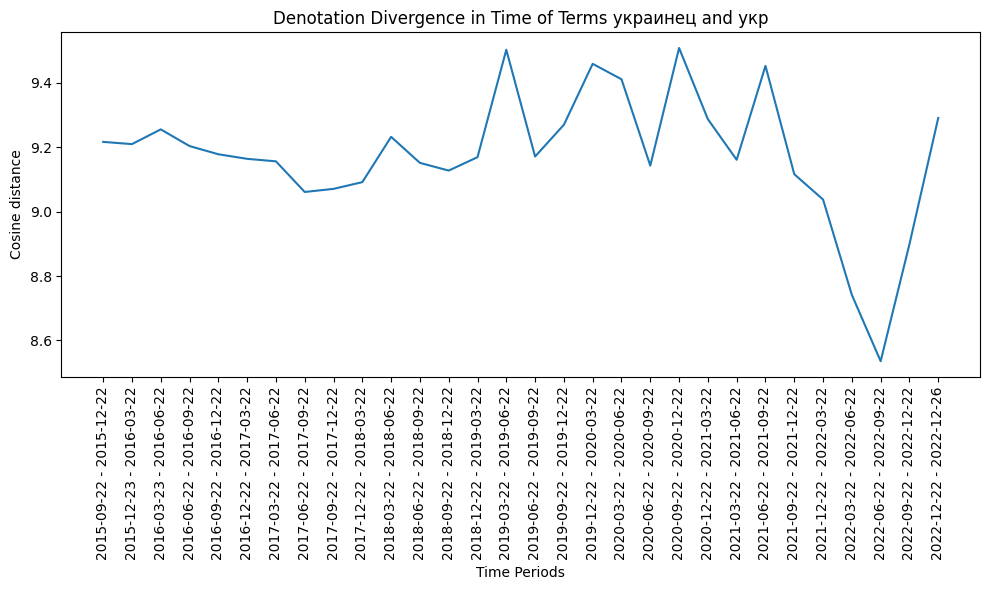

CPU times: user 1min 24s, sys: 9.9 s, total: 1min 33s
Wall time: 1min 40s


In [17]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинец', 'укр', models_path)

['украинец', 'украинца', 'украинцу', 'украинца', 'украинцем', 'украинце', 'украинцы', 'украинцев', 'украинцам', 'украинцев', 'украинцами', 'украинцах']
********************************************************************************
['хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохла', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлов', 'хохлами', 'хохлах']


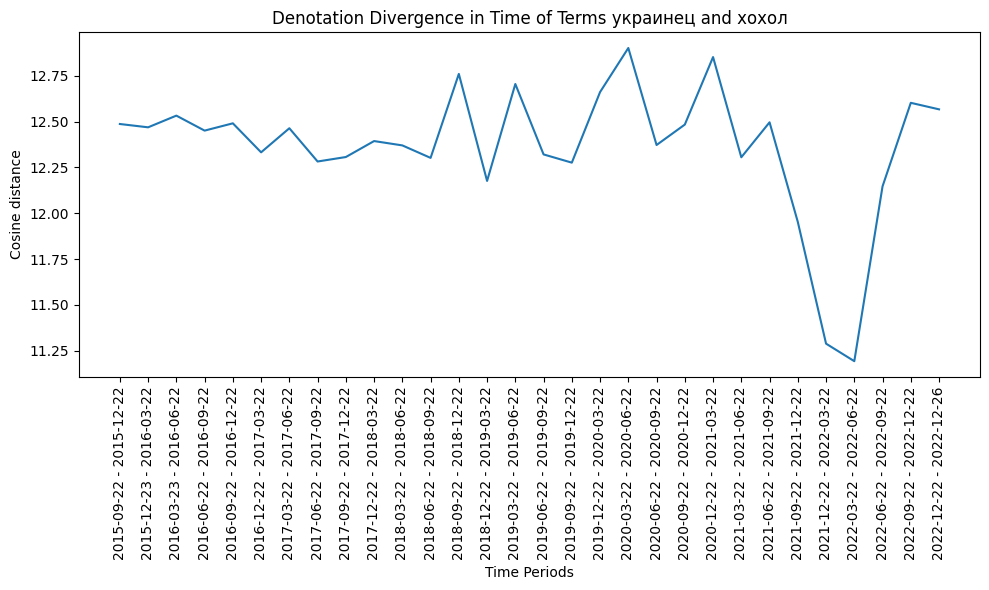

CPU times: user 1min 23s, sys: 10.1 s, total: 1min 33s
Wall time: 1min 40s


In [18]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинец', 'хохол', models_path)

['украинка', 'украинки', 'украинке', 'украинку', 'украинкой', 'украинкою', 'украинке', 'украинки', 'украинок', 'украинкам', 'украинок', 'украинками', 'украинках']
********************************************************************************
['хохлушка', 'хохлушки', 'хохлушке', 'хохлушку', 'хохлушкой', 'хохлушкою', 'хохлушке', 'хохлушки', 'хохлушек', 'хохлушкам', 'хохлушек', 'хохлушками', 'хохлушках']


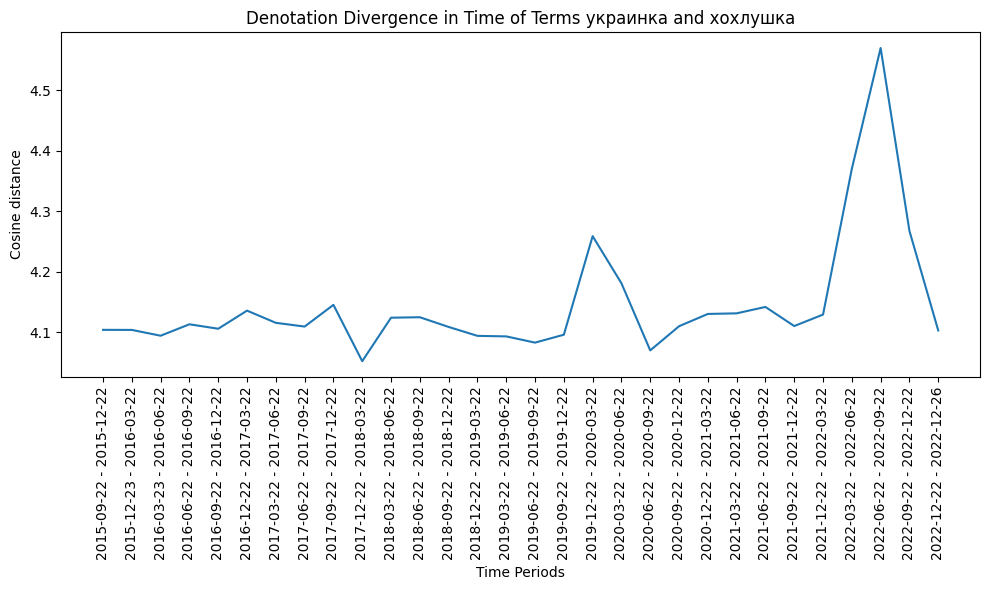

CPU times: user 1min 23s, sys: 9.94 s, total: 1min 33s
Wall time: 1min 43s


In [19]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинка', 'хохлушка', models_path)

In [20]:
all_forms_dict.keys()

dict_keys(['укр', 'украинец', 'украинка', 'хохол', 'хохлушка', 'укроп', 'Украина', 'украинский', 'украинская', 'украинское', 'хохлятский', 'хохлятская', 'хохлятское', 'укропский', 'укропская', 'укропское'])

['украинский', 'украинского', 'украинскому', 'украинского', 'украинский', 'украинским', 'украинском', 'украинская', 'украинской', 'украинской', 'украинскую', 'украинской', 'украинскою', 'украинской', 'украинское', 'украинского', 'украинскому', 'украинское', 'украинским', 'украинском', 'украинские', 'украинских', 'украинским', 'украинских', 'украинские', 'украинскими', 'украинских', 'украинский', 'украинского', 'украинскому', 'украинского', 'украинский', 'украинским', 'украинском', 'украинская', 'украинской', 'украинской', 'украинскую', 'украинской', 'украинскою', 'украинской', 'украинское', 'украинского', 'украинскому', 'украинское', 'украинским', 'украинском', 'украинские', 'украинских', 'украинским', 'украинских', 'украинские', 'украинскими', 'украинских']
********************************************************************************
['хохлятский', 'хохлятского', 'хохлятскому', 'хохлятского', 'хохлятский', 'хохлятским', 'хохлятском', 'хохлятская', 'хохлятской', 'хохлятской', 'хохля

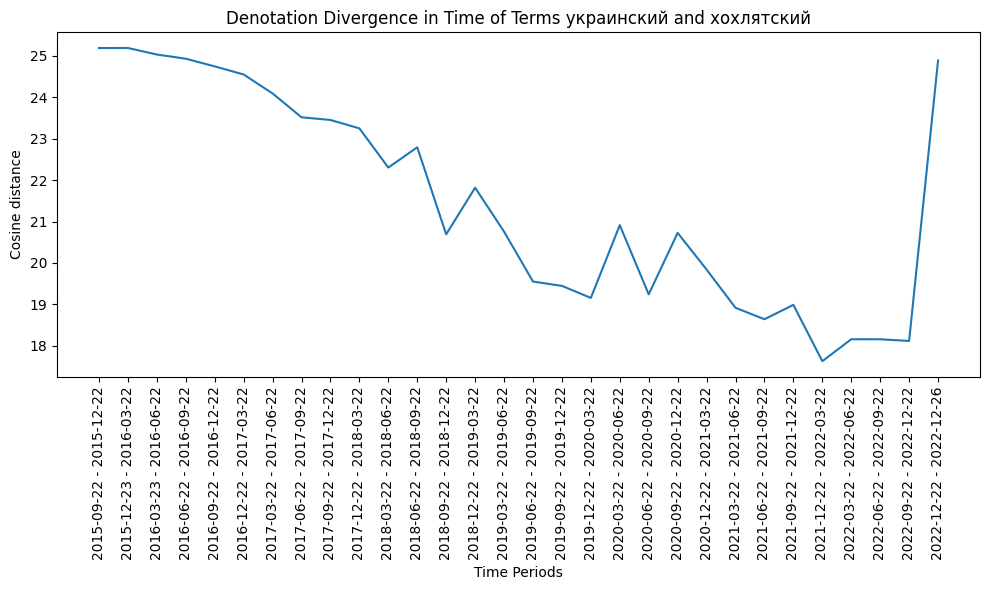

CPU times: user 1min 23s, sys: 9.89 s, total: 1min 33s
Wall time: 1min 43s


In [21]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинский', 'хохлятский', models_path)

['украинский', 'украинского', 'украинскому', 'украинского', 'украинский', 'украинским', 'украинском', 'украинская', 'украинской', 'украинской', 'украинскую', 'украинской', 'украинскою', 'украинской', 'украинское', 'украинского', 'украинскому', 'украинское', 'украинским', 'украинском', 'украинские', 'украинских', 'украинским', 'украинских', 'украинские', 'украинскими', 'украинских', 'украинский', 'украинского', 'украинскому', 'украинского', 'украинский', 'украинским', 'украинском', 'украинская', 'украинской', 'украинской', 'украинскую', 'украинской', 'украинскою', 'украинской', 'украинское', 'украинского', 'украинскому', 'украинское', 'украинским', 'украинском', 'украинские', 'украинских', 'украинским', 'украинских', 'украинские', 'украинскими', 'украинских']
********************************************************************************
['укропский', 'укропского', 'укропскому', 'укропского', 'укропский', 'укропским', 'укропском', 'укропская', 'укропской', 'укропской', 'укропскую', 'ук

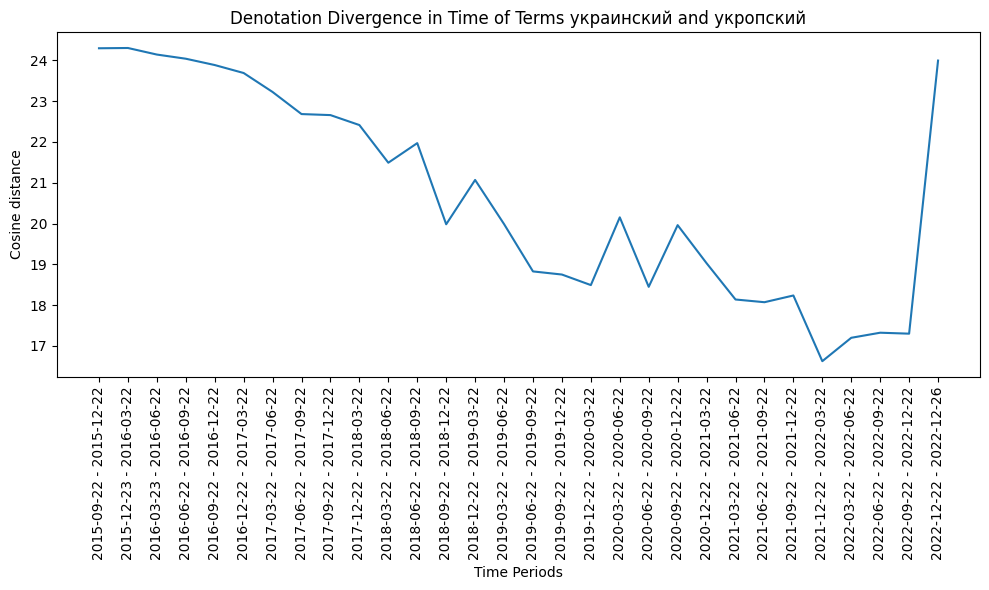

CPU times: user 1min 23s, sys: 9.94 s, total: 1min 33s
Wall time: 1min 43s


In [22]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинский', 'укропский', models_path)

['украинец', 'украинца', 'украинцу', 'украинца', 'украинцем', 'украинце', 'украинцы', 'украинцев', 'украинцам', 'украинцев', 'украинцами', 'украинцах']
********************************************************************************
['украинка', 'украинки', 'украинке', 'украинку', 'украинкой', 'украинкою', 'украинке', 'украинки', 'украинок', 'украинкам', 'украинок', 'украинками', 'украинках']


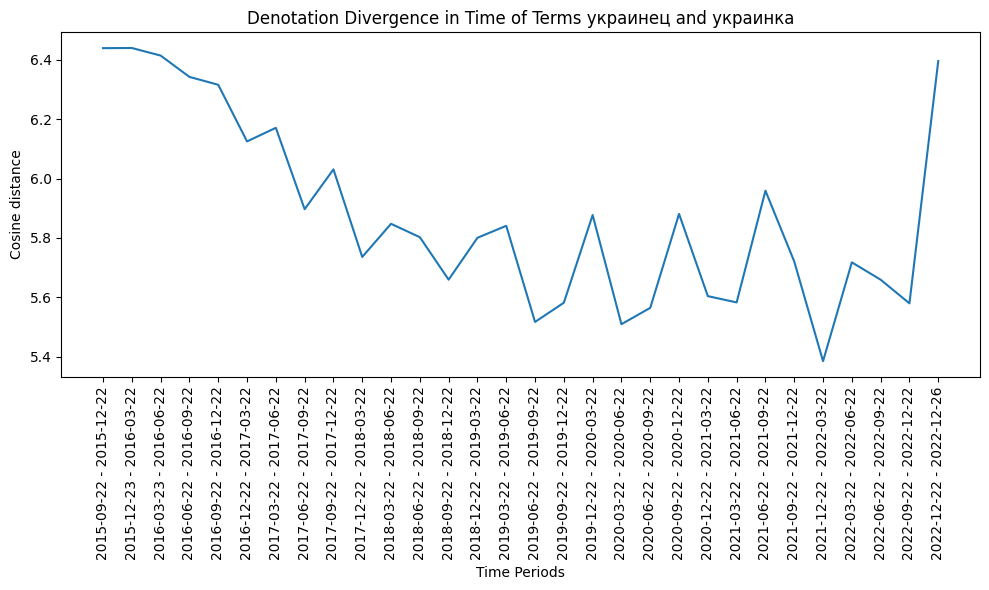

CPU times: user 1min 22s, sys: 9.69 s, total: 1min 32s
Wall time: 1min 42s


In [23]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинец', 'украинка', models_path)

['кот', 'кота', 'коту', 'кота', 'котом', 'коте', 'коты', 'котов', 'котам', 'котов', 'котами', 'котах']
********************************************************************************
['молоко', 'молока', 'молоку', 'молоко', 'молоком', 'молоке', 'молоко', 'молока', 'молоку', 'молоко', 'молоком', 'молоке']


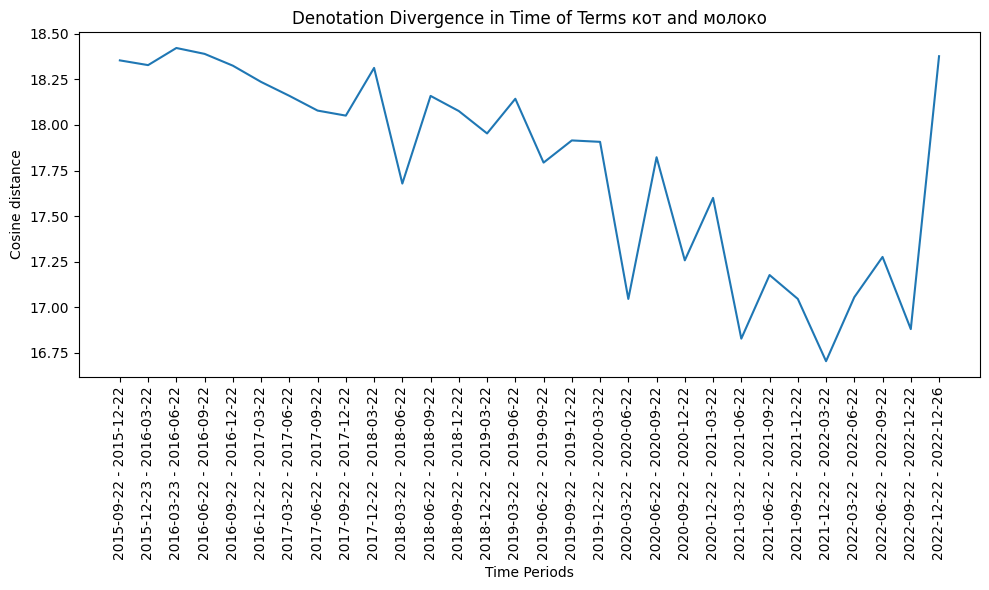

CPU times: user 1min 19s, sys: 9.38 s, total: 1min 29s
Wall time: 1min 39s


In [24]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'кот', 'молоко', models_path)

In [25]:
from scipy.spatial.distance import euclidean

def plot_denotation_divergence_w_time_eucl(all_forms_dict, term_one, term_two, models_path):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two)
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')

    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = euclidean(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date} - {end_date}')

    plt.figure(figsize=(10, 6))
    plt.plot(distance_list)
    plt.xticks(range(len(time_periods)), time_periods, rotation=90)
    plt.xlabel('Time Periods')
    plt.ylabel('Cosine distance')
    plt.title('Denotation Divergence in Time of Terms {} and {}'.format(term_one, term_two))
    plt.tight_layout()
    plt.show()

['кот', 'кота', 'коту', 'кота', 'котом', 'коте', 'коты', 'котов', 'котам', 'котов', 'котами', 'котах']
********************************************************************************
['молоко', 'молока', 'молоку', 'молоко', 'молоком', 'молоке', 'молоко', 'молока', 'молоку', 'молоко', 'молоком', 'молоке']


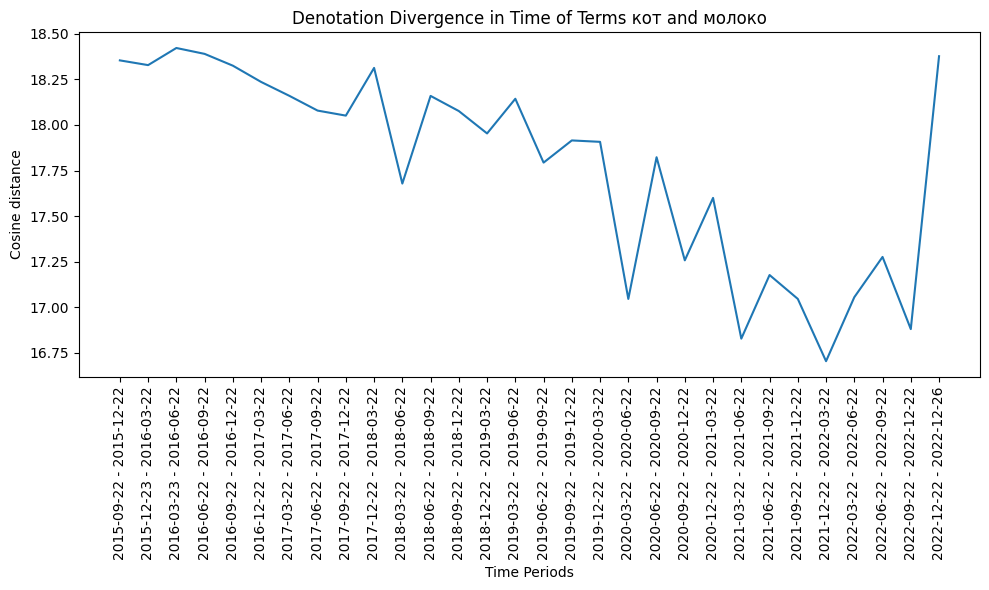

CPU times: user 1min 19s, sys: 9.49 s, total: 1min 29s
Wall time: 1min 39s


In [26]:
%%time

plot_denotation_divergence_w_time_eucl(all_forms_dict, 'кот', 'молоко', models_path)

![post dynamics](/Users/katerynaburovova/PycharmProjects/dehumanization/pics/posts_over_time.png)

In [27]:
from scipy.spatial.distance import cityblock

def plot_denotation_divergence_w_time_manh(all_forms_dict, term_one, term_two, models_path):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two)
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')

    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = cityblock(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date} - {end_date}')

    plt.figure(figsize=(10, 6))
    plt.plot(distance_list)
    plt.xticks(range(len(time_periods)), time_periods, rotation=90)
    plt.xlabel('Time Periods')
    plt.ylabel('Cosine distance')
    plt.title('Denotation Divergence in Time of Terms {} and {}'.format(term_one, term_two))
    plt.tight_layout()
    plt.show()

['кот', 'кота', 'коту', 'кота', 'котом', 'коте', 'коты', 'котов', 'котам', 'котов', 'котами', 'котах']
********************************************************************************
['молоко', 'молока', 'молоку', 'молоко', 'молоком', 'молоке', 'молоко', 'молока', 'молоку', 'молоко', 'молоком', 'молоке']


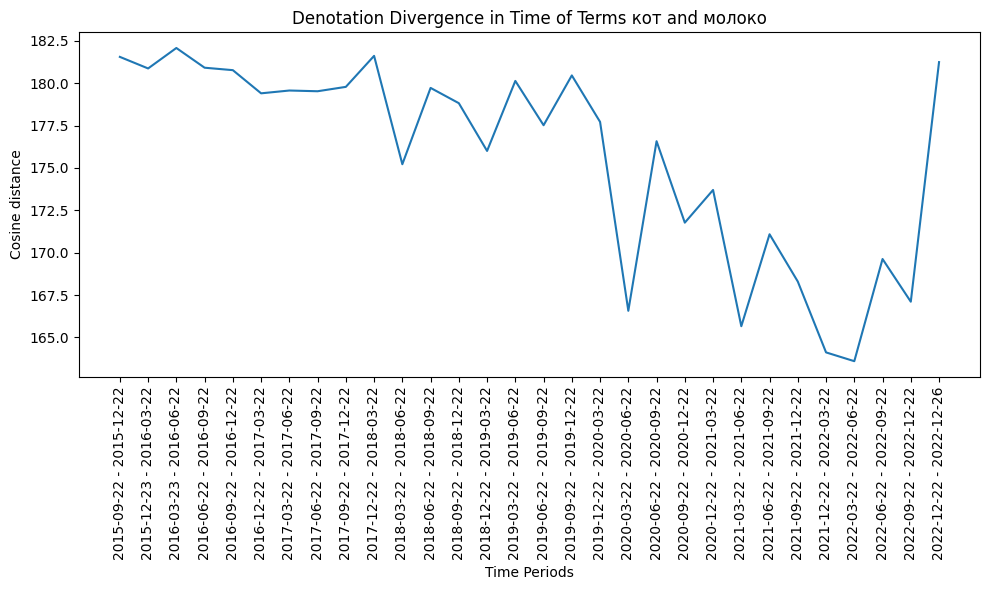

CPU times: user 1min 20s, sys: 9.58 s, total: 1min 29s
Wall time: 1min 39s


In [28]:
%%time

plot_denotation_divergence_w_time_manh(all_forms_dict, 'кот', 'молоко', models_path)

['телеканал', 'телеканала', 'телеканалу', 'телеканал', 'телеканалом', 'телеканале', 'телеканалы', 'телеканалов', 'телеканалам', 'телеканалы', 'телеканалами', 'телеканалах', 'телеканал', 'телеканала', 'телеканалу', 'телеканал', 'телеканалом', 'телеканале', 'телеканалы', 'телеканалов', 'телеканалам', 'телеканалы', 'телеканалами', 'телеканалах']
********************************************************************************
['зритель', 'зрителя', 'зрителю', 'зрителя', 'зрителем', 'зрителе', 'зрители', 'зрителей', 'зрителям', 'зрителей', 'зрителями', 'зрителях']


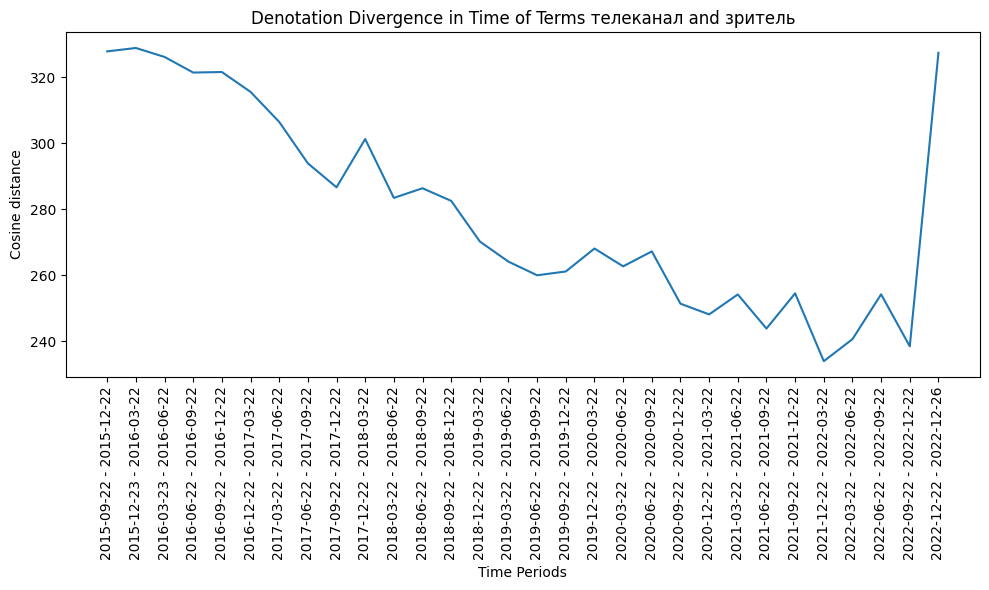

CPU times: user 1min 19s, sys: 9.52 s, total: 1min 29s
Wall time: 1min 39s


In [29]:
%%time

plot_denotation_divergence_w_time_manh(all_forms_dict, 'телеканал', 'зритель', models_path)

## For 5 epochs

['укр', 'укра', 'укру', 'укром', 'укре', 'укры', 'укров', 'украм', 'украми', 'украх']
********************************************************************************
['хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохла', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлов', 'хохлами', 'хохлах']


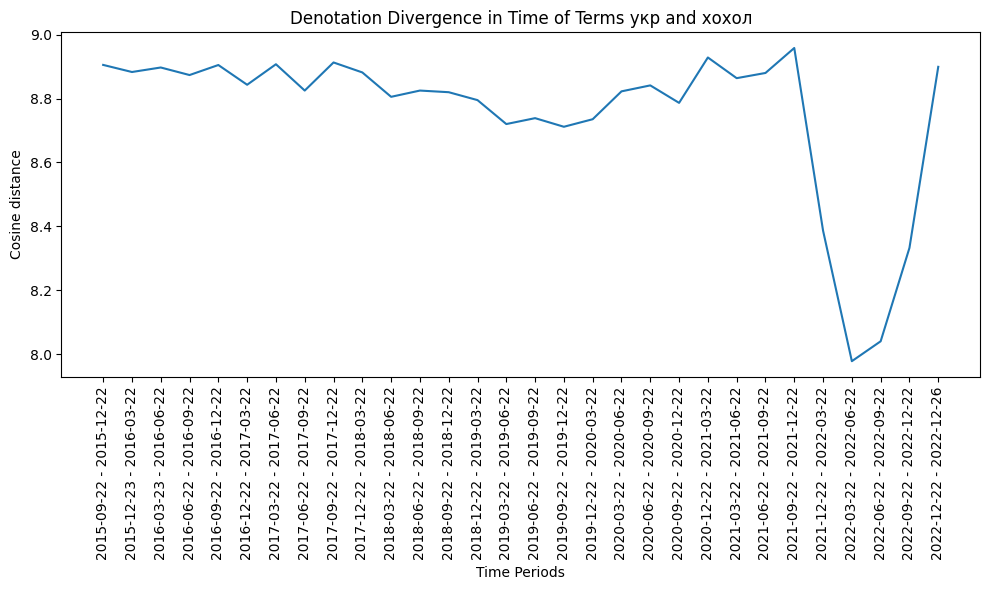

CPU times: user 1min 19s, sys: 8.33 s, total: 1min 28s
Wall time: 1min 30s


In [30]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'укр', 'хохол', models_path_few_epoch)

['украинец', 'украинца', 'украинцу', 'украинца', 'украинцем', 'украинце', 'украинцы', 'украинцев', 'украинцам', 'украинцев', 'украинцами', 'украинцах']
********************************************************************************
['укр', 'укра', 'укру', 'укром', 'укре', 'укры', 'укров', 'украм', 'украми', 'украх']


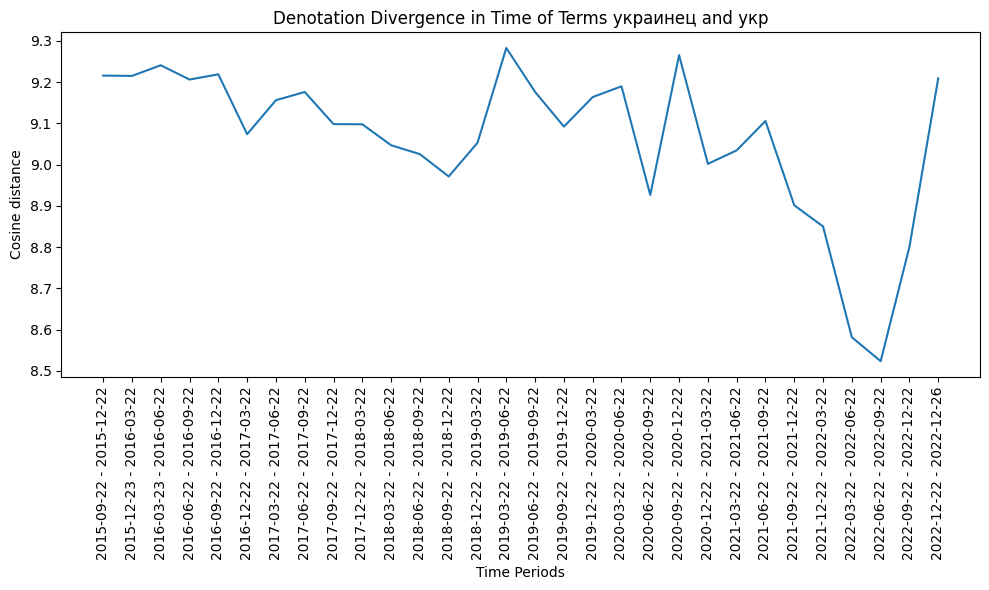

CPU times: user 1min 19s, sys: 8.08 s, total: 1min 27s
Wall time: 1min 29s


In [31]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинец', 'укр', models_path_few_epoch)

['украинка', 'украинки', 'украинке', 'украинку', 'украинкой', 'украинкою', 'украинке', 'украинки', 'украинок', 'украинкам', 'украинок', 'украинками', 'украинках']
********************************************************************************
['хохлушка', 'хохлушки', 'хохлушке', 'хохлушку', 'хохлушкой', 'хохлушкою', 'хохлушке', 'хохлушки', 'хохлушек', 'хохлушкам', 'хохлушек', 'хохлушками', 'хохлушках']


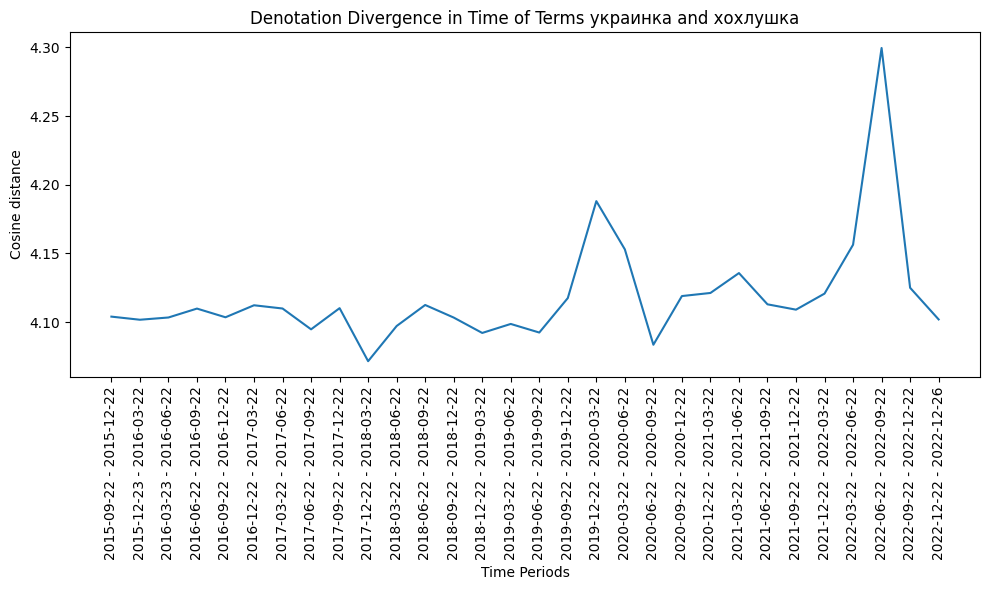

CPU times: user 1min 19s, sys: 8.13 s, total: 1min 27s
Wall time: 1min 29s


In [32]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинка', 'хохлушка', models_path_few_epoch)

['украинский', 'украинского', 'украинскому', 'украинского', 'украинский', 'украинским', 'украинском', 'украинская', 'украинской', 'украинской', 'украинскую', 'украинской', 'украинскою', 'украинской', 'украинское', 'украинского', 'украинскому', 'украинское', 'украинским', 'украинском', 'украинские', 'украинских', 'украинским', 'украинских', 'украинские', 'украинскими', 'украинских', 'украинский', 'украинского', 'украинскому', 'украинского', 'украинский', 'украинским', 'украинском', 'украинская', 'украинской', 'украинской', 'украинскую', 'украинской', 'украинскою', 'украинской', 'украинское', 'украинского', 'украинскому', 'украинское', 'украинским', 'украинском', 'украинские', 'украинских', 'украинским', 'украинских', 'украинские', 'украинскими', 'украинских']
********************************************************************************
['хохлятский', 'хохлятского', 'хохлятскому', 'хохлятского', 'хохлятский', 'хохлятским', 'хохлятском', 'хохлятская', 'хохлятской', 'хохлятской', 'хохля

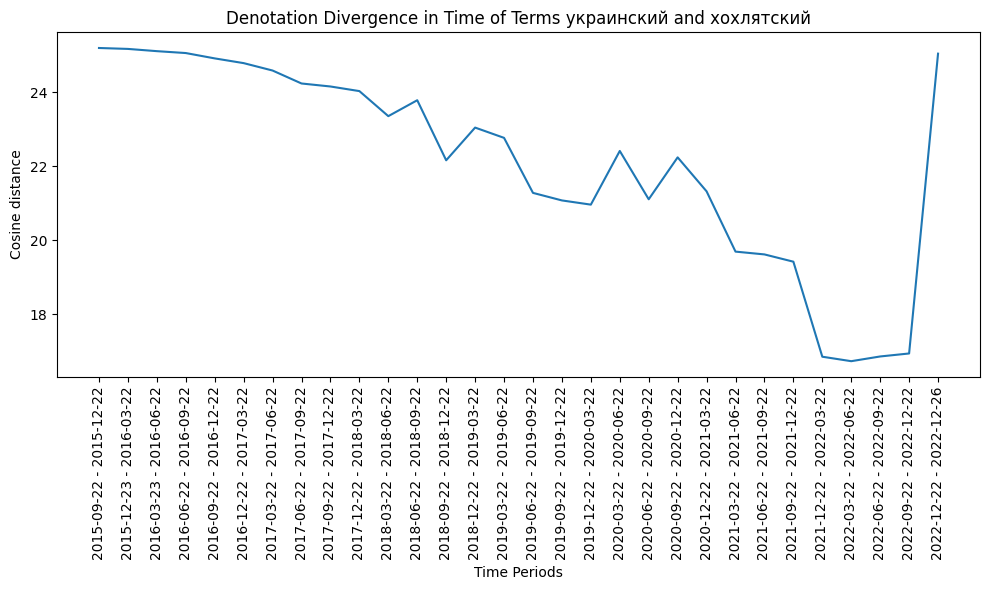

CPU times: user 1min 19s, sys: 8.13 s, total: 1min 27s
Wall time: 1min 30s


In [33]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинский', 'хохлятский', models_path_few_epoch)

['хохлятский', 'хохлятского', 'хохлятскому', 'хохлятского', 'хохлятский', 'хохлятским', 'хохлятском', 'хохлятская', 'хохлятской', 'хохлятской', 'хохлятскую', 'хохлятской', 'хохлятскою', 'хохлятской', 'хохлятское', 'хохлятского', 'хохлятскому', 'хохлятское', 'хохлятским', 'хохлятском', 'хохлятские', 'хохлятских', 'хохлятским', 'хохлятских', 'хохлятские', 'хохлятскими', 'хохлятских', 'хохлятский', 'хохлятского', 'хохлятскому', 'хохлятского', 'хохлятский', 'хохлятским', 'хохлятском', 'хохлятская', 'хохлятской', 'хохлятской', 'хохлятскую', 'хохлятской', 'хохлятскою', 'хохлятской', 'хохлятское', 'хохлятского', 'хохлятскому', 'хохлятское', 'хохлятским', 'хохлятском', 'хохлятские', 'хохлятских', 'хохлятским', 'хохлятских', 'хохлятские', 'хохлятскими', 'хохлятских', 'хохлятский', 'хохлятского', 'хохлятскому', 'хохлятского', 'хохлятским', 'хохлятском', 'хохлятская', 'хохлятской', 'хохлятской', 'хохлятскую', 'хохлятской', 'хохлятской', 'хохлятские', 'хохлятских', 'хохлятским', 'хохлятских', 'хох

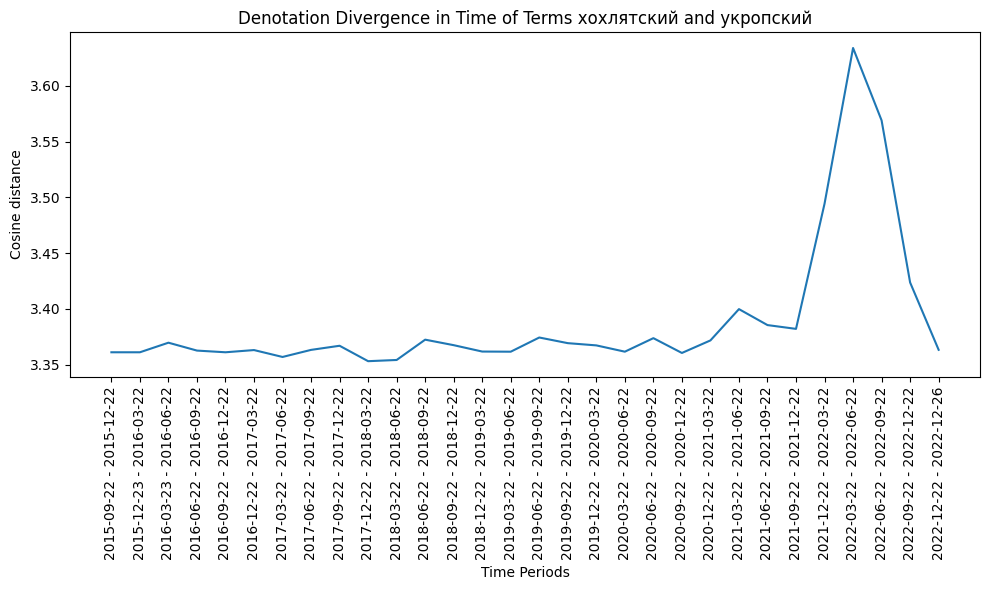

CPU times: user 1min 19s, sys: 8.1 s, total: 1min 27s
Wall time: 1min 30s


In [34]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'хохлятский', 'укропский', models_path_few_epoch)

## For 20 ep

['укронацик', 'укронацика', 'укронацику', 'укронацика', 'укронациком', 'укронацике', 'укронацики', 'укронациков', 'укронацикам', 'укронациков', 'укронациками', 'укронациках']
********************************************************************************
['украинец', 'украинца', 'украинцу', 'украинца', 'украинцем', 'украинце', 'украинцы', 'украинцев', 'украинцам', 'украинцев', 'украинцами', 'украинцах']


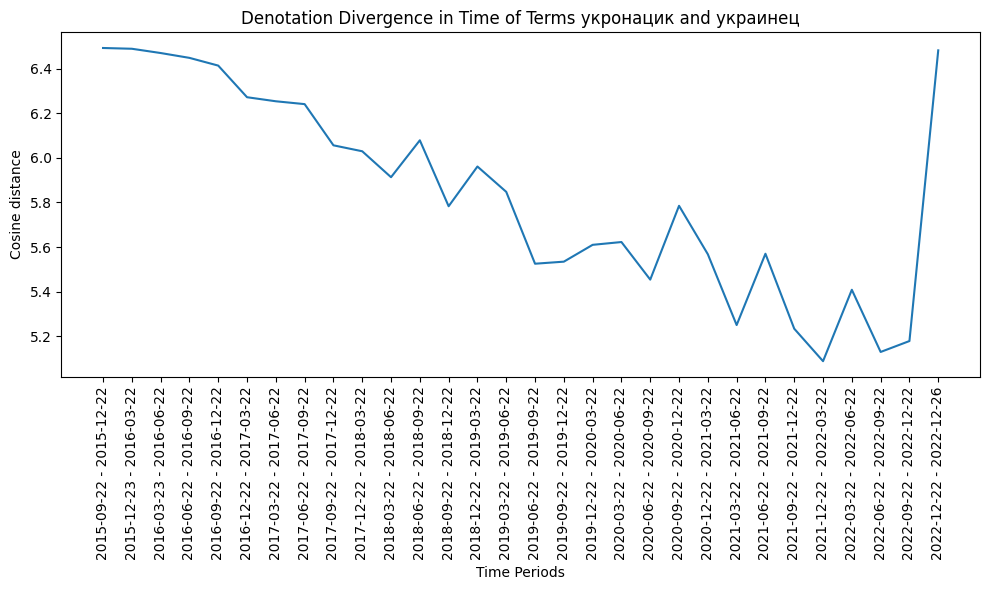

CPU times: user 1min 19s, sys: 8.06 s, total: 1min 27s
Wall time: 1min 29s


In [35]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'укронацик', 'украинец', models_path_few_epoch)

['укр', 'укра', 'укру', 'укром', 'укре', 'укры', 'укров', 'украм', 'украми', 'украх']
********************************************************************************
['хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохла', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлов', 'хохлами', 'хохлах']


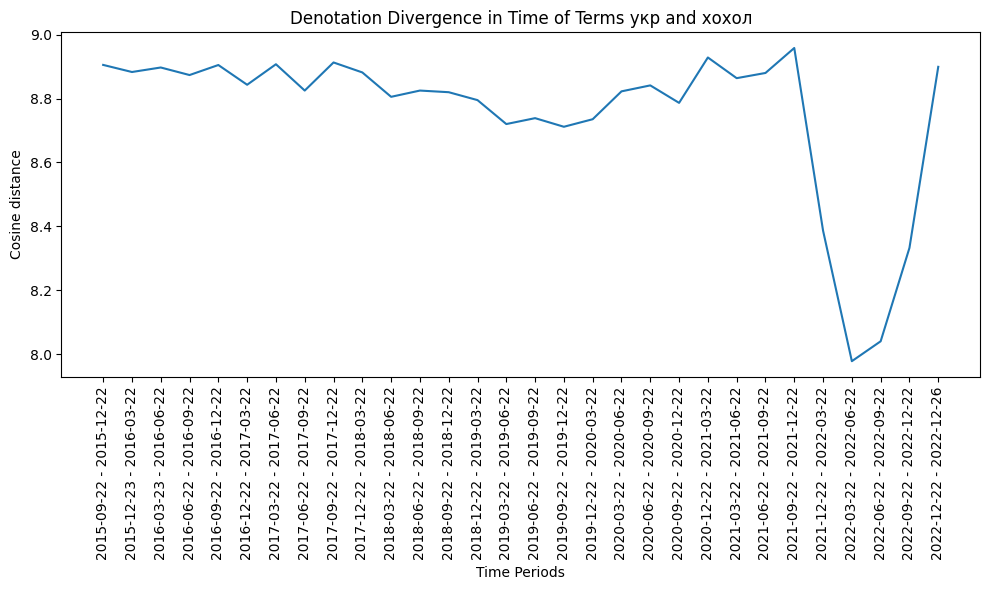

CPU times: user 1min 19s, sys: 8.08 s, total: 1min 27s
Wall time: 1min 30s


In [36]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'укр', 'хохол', models_path_few_epoch)

['укр', 'укра', 'укру', 'укром', 'укре', 'укры', 'укров', 'украм', 'украми', 'украх']
********************************************************************************
['хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохла', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлов', 'хохлами', 'хохлах']


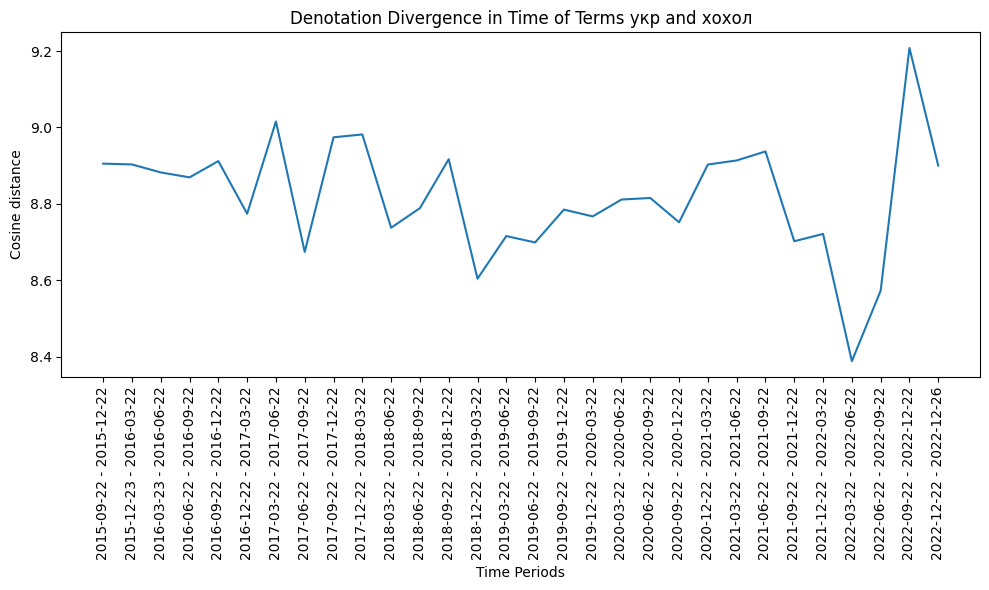

CPU times: user 1min 21s, sys: 9.42 s, total: 1min 30s
Wall time: 2h 19min 32s


In [37]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'укр', 'хохол', models_path)

['украинец', 'украинца', 'украинцу', 'украинца', 'украинцем', 'украинце', 'украинцы', 'украинцев', 'украинцам', 'украинцев', 'украинцами', 'украинцах']
********************************************************************************
['хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохла', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлов', 'хохлами', 'хохлах']


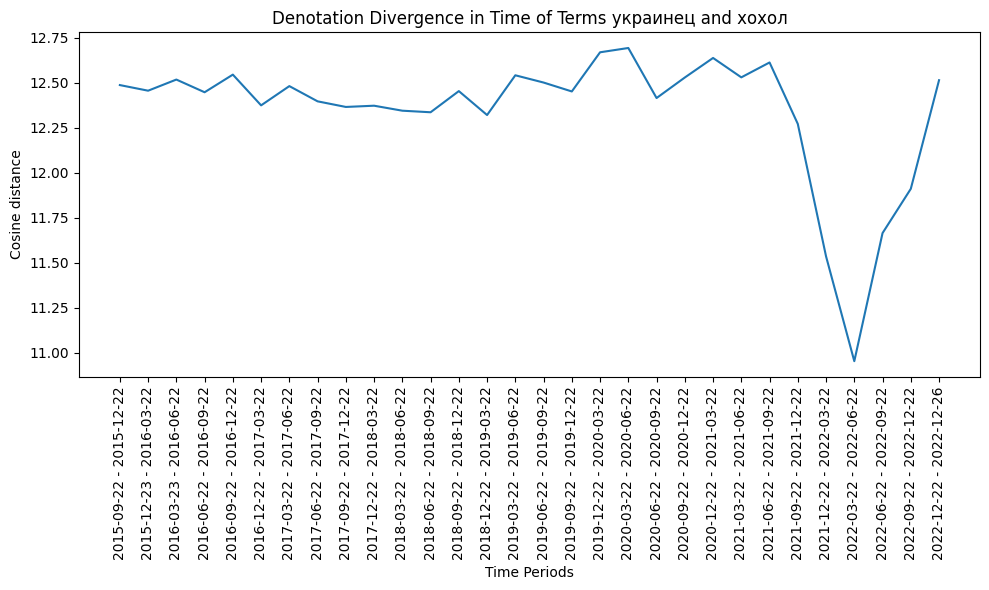

CPU times: user 1min 22s, sys: 9.37 s, total: 1min 31s
Wall time: 5min 45s


In [38]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'украинец', 'хохол', models_path_few_epoch)

['укронацик', 'укронацика', 'укронацику', 'укронацика', 'укронациком', 'укронацике', 'укронацики', 'укронациков', 'укронацикам', 'укронациков', 'укронациками', 'укронациках']
********************************************************************************
['украинец', 'украинца', 'украинцу', 'украинца', 'украинцем', 'украинце', 'украинцы', 'украинцев', 'украинцам', 'украинцев', 'украинцами', 'украинцах']


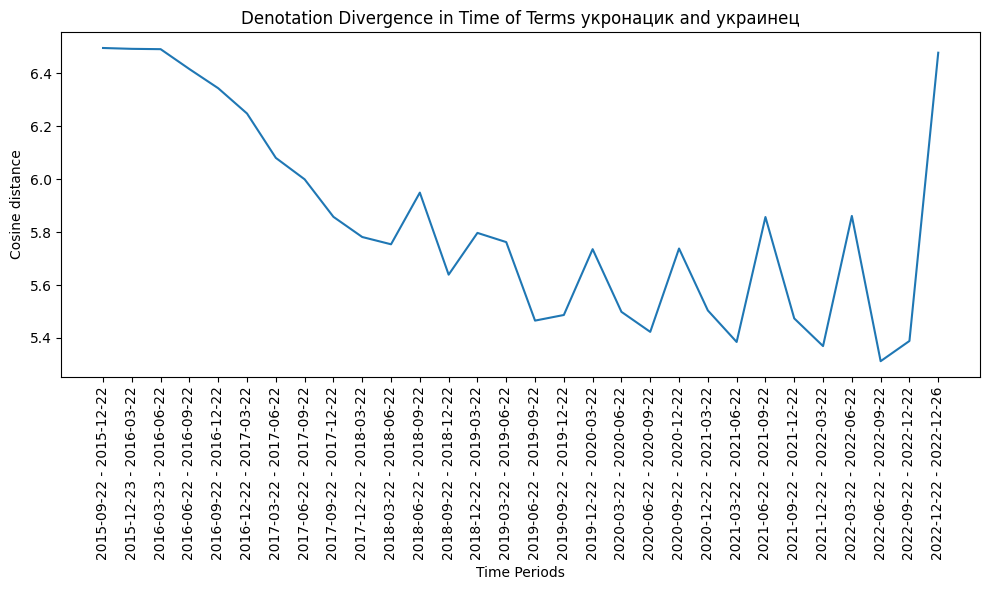

CPU times: user 1min 23s, sys: 9.76 s, total: 1min 33s
Wall time: 1min 44s


In [39]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'укронацик', 'украинец', models_path)

['укронацик', 'укронацика', 'укронацику', 'укронацика', 'укронациком', 'укронацике', 'укронацики', 'укронациков', 'укронацикам', 'укронациков', 'укронациками', 'укронациках']
********************************************************************************
['украинец', 'украинца', 'украинцу', 'украинца', 'украинцем', 'украинце', 'украинцы', 'украинцев', 'украинцам', 'украинцев', 'украинцами', 'украинцах']


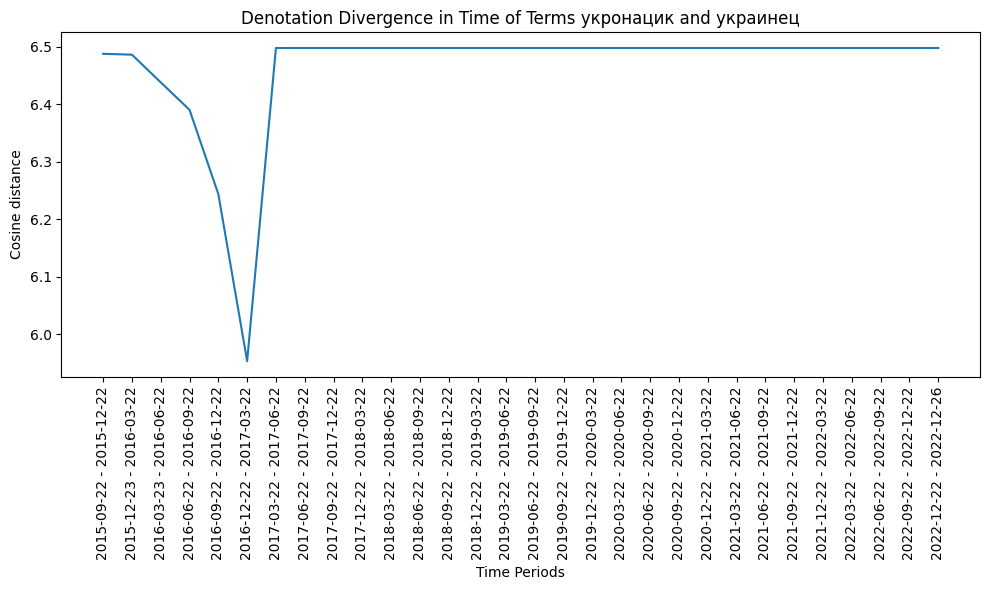

CPU times: user 1min 24s, sys: 8.51 s, total: 1min 32s
Wall time: 1min 34s


In [40]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'укронацик', 'украинец', models_path_more_epoch)

['укр', 'укра', 'укру', 'укром', 'укре', 'укры', 'укров', 'украм', 'украми', 'украх']
********************************************************************************
['хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохол', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлы', 'хохлами', 'хохлах', 'хохол', 'хохла', 'хохлу', 'хохла', 'хохлом', 'хохле', 'хохлы', 'хохлов', 'хохлам', 'хохлов', 'хохлами', 'хохлах']


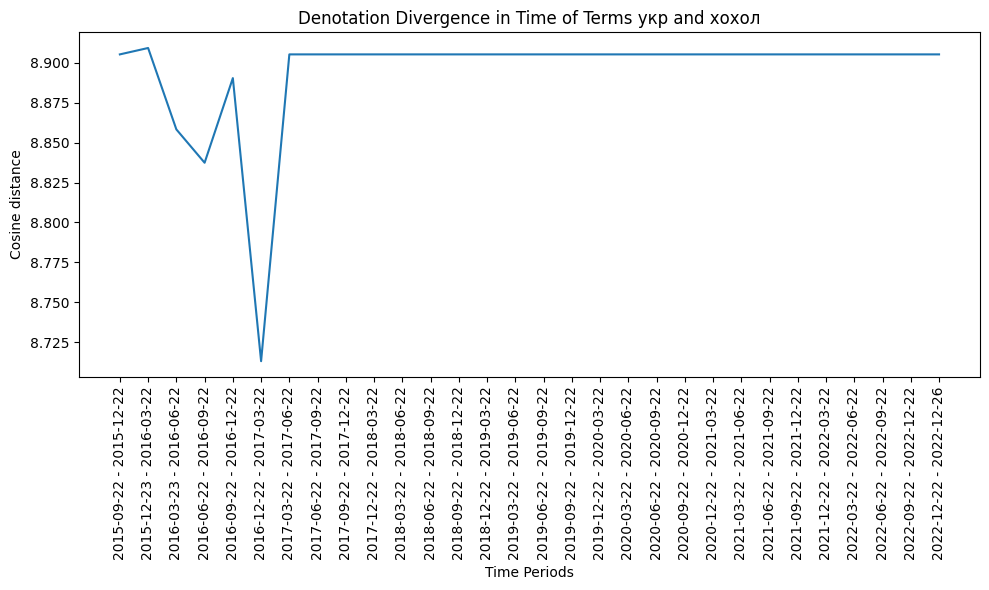

CPU times: user 1min 24s, sys: 9.09 s, total: 1min 33s
Wall time: 1min 36s


In [41]:
%%time

plot_denotation_divergence_w_time(all_forms_dict, 'укр', 'хохол', models_path_more_epoch)